In [1]:
import os
import gzip
import bisect
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 1. Load data

* **Source**: Project Stork (private repo)

We will have more cleaning efforts here, because the set of words is generated automatically by parsing web sites, books, chats and forums (a lot of noise exists).

#### Data gathering
A private dataset of Bulgarian texts have been created. 

It corpus contains:
* `700M` sentences
* `3B` words

The texts have been fetched from different sources:
* books (literature)
* news, websites (formal language)
* chats/forums (informal language)

The set is not balanced in terms of formal vs casual speech, but at least it is highly heterogeneous.

After parsing all the documents and the sentences in them, all unique words have been TF-IDF-scored. In result we came up with a `ranking of 10M` unique Bulgarian words. The **first 10%** of the list (**highest TF-IDF scores**) will be loaded here.


<center><img src="img/stork_data_pipeline.png" alt="Two weighted dices" width="1236" height="633" /></center>
<p style="text-align: center; font-size: small;"><i><b>Figure 1.</b> Project Stork Data Pipeline </i></p>

The TF-IDF score has been calculated by custom formula:
$$ TF\_IDF = TF * IDF $$
where
$$ TF = log(1 + CORPUS\_FREQ) $$
$$ CORPUS\_FREQ = \sum_{i=1}^{\text{\# of sent}} { \text{SENT\_FREQ} } $$
$$ SENT\_FREQ = \frac{\text{word ocurrences in sentence}}{\text{\# of words in sentence}} $$
and
$$ IDF = log(\frac{\text{total \# of sentences}}{\text{\# of sentences containing the word}} ) $$

---

**Example**: `ти си мое дете и мое слънце`.
$$ SENT\_FREQ(\text{мое}) = 2 / 7 = 0.286$$

The corpus frequency is basically the sum of all *sentence frequencies*.

$$ CORPUS\_FREQ(\text{мое}) = 0.286 + 0 + 0.09 + ... + 0 = 43,741.604 $$

$$ TF = log(1 + 43,741.604) = 4.64$$
 
$$ IDF(\text{мое}) = log(\frac{700,000,000}{200,000}) = 3.5$$

$$ TF\_IDF = 4.64 * 3.5 = 16.24 $$

---
After calculating all $TF\_IDF$ scores, we normalize them to fit into $[0, 1]$ range:
$$ \text{normalized\_score} = \frac{\text{score} - \text{min\_score}} {\text{max\_score} - \text{min\_score}} $$
where $\text{max\_score}$ and $ \text{min\_score}$ are the maximum and minimum scores for the whole set of words.

In [2]:
# Read the csv file in the gzip archive
words_df = pd.read_csv('data/6_project_stork.csv.gz', encoding='windows-1251', compression='gzip', header=None, names=['word', 'tfidf'])
words_df.index.name = 'id'
print(f"Total words count: {len(words_df):,}")
words_df.head(10)

Total words count: 1,294,882


,word,tfidf
id,,
0,чекирайте,1.000000
1,посетен,0.975713
2,предавателно,0.969000
3,чекирал,0.965638
4,намръщи,0.956391
5,сигнализиран,0.952446
6,поклати,0.945294
7,изсмя,0.945094
8,изсумтя,0.945068


In [3]:
words_df.sample(10)

,word,tfidf
id,,
202222,порядъчността,0.611263
113831,марксистите,0.719292
141524,траела,0.683011
1082253,копейкиновата,0.182805
644463,квантиферон,0.302815
1180346,некомбиниран,0.166392
146317,келоиди,0.677003
20834,спирулина,0.843280
677871,слипстрийм,0.289614


* **OBSERVATION**: Invalid words can be easily detected in the lower part of the ranking (probably, below score `0.5`). We need to test somehow where is the border line, i.e. where the first invalid word occur and how the % of invalid units changes after going down the ranking.

## 2. Spaced words

In [4]:
spaced_words = words_df[words_df['word'].str.contains(" ")]
print(f"Number of spaced words: {len(spaced_words):,}")

Number of spaced words: 0


* **OBSERVATION**: There are no spaces words, which is expected, knowing how the word-split has been performed in Stork Data Pipeline.

## 3. Dashed words

In [5]:
dashed_words = words_df[words_df['word'].str.contains("-")]
print(f"Number of dashed words: {len(dashed_words):,}")

Number of dashed words: 0


* **OBSERVATION**: There are no dashed words. Again - expected.

## 4. Capitalized words (names)

In [6]:
# Extract all names that start with a capital letter
names_df = words_df[words_df['word'].str.match(r'^[А-Я]')]
print(f"Number of names: {len(names_df):,}")

Number of names: 0


* **OBSERVATION**: There are no capitalized words. Expected.

## 5. Latin symbols

In [7]:
# Print words that contain latin symbols
latin_words = words_df[words_df['word'].str.contains(r'[a-zA-Z]')]
print(f"Number of words with latin symbols: {len(latin_words):,}")

Number of words with latin symbols: 0


* **OBSERVATION**: There are no latin symbols. Expected.

## 6. Punctuation & digits

In [8]:
# Is there words with anything different than letters?
print(f"Number of words with anything different than letters: {words_df[words_df['word'].str.contains(r'[^\w]')].shape[0]:,}")

Number of words with anything different than letters: 0


* **OBSERVATION**: No punctuation, nor digits. Expected.

## 7. Duplicates

In [9]:
# Are there duplicated words?
print(f"Duplicated words: {len(words_df[words_df.word.duplicated()]):,}")

Duplicated words: 0


* **OBSERVATION**: No duplications either!

## 8. Length distribution

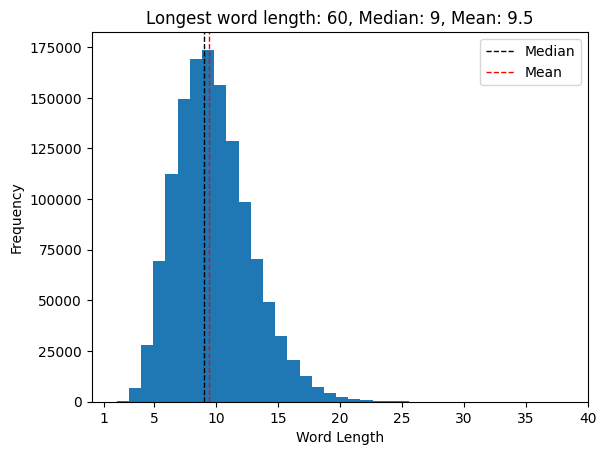

In [10]:
word_lengths = words_df['word'].str.len()
mean_length = word_lengths.mean()
median_length = word_lengths.median()
word_longest = word_lengths.max()
plt.hist(word_lengths, bins=word_longest-1)
plt.axvline(median_length, color='black', linestyle='dashed', linewidth=1)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1)
plt.legend(['Median', 'Mean'])
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title(f'Longest word length: {word_longest}, Median: {median_length:.0f}, Mean: {mean_length:.1f}')
plt.xticks([1, 5, 10, 15, 20, 25, 30, 35, 40])
plt.xlim(0, 40)
plt.show()

* **OBSERVATION**: The mean and the median looks consistent with the other datasets. However, the longest word surpass the longest word in Bulgarian language (`непротивоконституционствувателствувалият`) which has 40 letters.


Let's see check these long words.

In [11]:
# Print the longest words
fourty_one_plus_letter_words = words_df[words_df['word'].str.len() >= 41]
print(f"Number of 41+ letter words: {len(fourty_one_plus_letter_words):,}")
fourty_one_plus_letter_words.sample(20)

Number of 41+ letter words: 47


,word,tfidf
id,,
1151670,каталогконтактигалерииизвестникизвестиядоктора...,0.170978
733940,стопанствоорганизацииенергетикаинформационни,0.269680
1140484,машинателевизордушотоплениехладилниккухняпералня,0.172829
327906,наименованиестилстандартниенергоспестяващимогат,0.489782
983722,албумпеснисинглитурнеобложкиизданиятекстове,0.202145
1027273,градовебанскоямболхасковоблагоевградврацавидин...,0.193205
665426,пресимазниниотслабванетренировкаупражненияупра...,0.294376
1054348,началоексклузивнокалейдоскопрелигияздраве,0.187956
1208722,засегнатоотвременнитепротивоепидемичнимерки,0.162082


* **OBSERVATION**: As expected, these are invalid words. Some of them contain 1 or 2 letters only (these are easy to be identified). Others are simply created by stitching multiple valid words.

In [12]:
# Firstly, we can safely remove all words with 41+ letters
words_df = words_df[words_df['word'].str.len() < 41]
print(f"Number of words after removing words with 41+ letters: {len(words_df):,}")

Number of words after removing words with 41+ letters: 1,294,835


## 9. Remove same-letter words

In [13]:
# Check the words that contain the same letter three times
three_letter_words_df = words_df[words_df['word'].str.contains(r'(\w)\1{2}')]
print(f"Number of words with the same letter three times: {len(three_letter_words_df):,}")
three_letter_words_df.head(20)

C:\Users\mdzho\AppData\Local\Temp\ipykernel_8028\4107147024.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  three_letter_words_df = words_df[words_df['word'].str.contains(r'(\w)\1{2}')]


Number of words with the same letter three times: 8,157


,word,tfidf
id,,
1494,ммм,0.879062
16599,мммм,0.847826
19054,гооол,0.845165
36921,мнооооого,0.825439
38855,лелеее,0.823016
39066,ххх,0.822723
41705,иии,0.819420
42405,ееех,0.818515
42696,беее,0.818152


* **OBSERVATION**: These are incorrectly spelled interjections (междуметия) in spoken language. And these are not valid Bulgarian words.
So, we assume that we can safely remove all such words (with 3 consecutive same letters).

In [14]:
words_df = words_df[~words_df['word'].str.contains(r'(\w)\1{2}')]
print(f"Number of words after removing words with 3 consecutive same letters: {len(words_df):,}")

C:\Users\mdzho\AppData\Local\Temp\ipykernel_8028\1572709988.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  words_df = words_df[~words_df['word'].str.contains(r'(\w)\1{2}')]


Number of words after removing words with 3 consecutive same letters: 1,286,678


## 10. Remove words with only 2 unique letters

What about words like `ахахаха`. We don't need them either.

In [15]:
words_df['unique_letters_count'] = words_df['word'].apply(lambda x: len(set(x)))
print(f"Number of words with 2 unique letters: {len(words_df[words_df['unique_letters_count'] == 2]):,}")
print(f"Number of words with 3 unique letters: {len(words_df[words_df['unique_letters_count'] == 3]):,}")
print(f"Number of words with 4 unique letters: {len(words_df[words_df['unique_letters_count'] == 4]):,}")

Number of words with 2 unique letters: 1,949
Number of words with 3 unique letters: 14,534
Number of words with 4 unique letters: 55,885


In [16]:
# Identify words for which the number of unique letters is 2 and their length is 6+
two_unique_letters_words_df = words_df[(words_df['unique_letters_count'] == 2) & (words_df['word'].str.len() >= 6)]
print(f"Number of words with 2 unique letters and length 6+: {len(two_unique_letters_words_df):,}")
print(two_unique_letters_words_df['word'].tolist())

Number of words with 2 unique letters and length 6+: 478
['хахахаха', 'тотото', 'хахахах', 'хихихи', 'теетет', 'ахахаха', 'хахахахах', 'хахахха', 'хохохо', 'хихихихи', 'ахахах', 'хаххаха', 'лелеле', 'тцтцтц', 'хахахахахахахаха', 'хахахахахахах', 'хохохохо', 'хахахх', 'хахахахахахахахаха', 'ахахахахах', 'хахахахх', 'хаххахаха', 'хехехехехе', 'хахахаххаха', 'хихихих', 'хахахахахха', 'ахахахахахаха', 'хихихихихи', 'хахаах', 'хахахахаа', 'ххахаха', 'хахаххах', 'лелелеле', 'ахахха', 'хахахахахахахахахаха', 'хахахаах', 'хаххах', 'хахахахахахахах', 'хахаххаа', 'ахахахха', 'хаххаа', 'тцтцтцтц', 'пупупу', 'хахаххахаха', 'аххаха', 'хахаххахах', 'ахахахахахах', 'хаххахах', 'хахахахахахахахахахаха', 'ахахахахахахаха', 'хихихихии', 'ахаххаха', 'хахааха', 'хахахаххахаха', 'ххахах', 'хахахахаххаха', 'татата', 'ххахахаха', 'хахахахахахха', 'лалала', 'хахахахаах', 'хехехехех', 'хаахаха', 'аххахаха', 'дадада', 'хихихихих', 'хахахахахаа', 'хахахахахахахахах', 'хахахахахахахахахахахаха', 'ляляля', 'ахахах

* **OBSERVATION**: There is a single valid word here `тотото`. All the rest can be removed.

In [17]:
# Filter `тотото`
two_unique_letters_words_df = words_df[words_df['word'].str.contains('тотото')]

# Remove from `words_df` all words from two_unique_letters_words_df
words_df = words_df[~words_df['word'].isin(two_unique_letters_words_df['word'])]
print(f"Number of words after removing `two_unique_letters_words_df`: {len(words_df):,}")

Number of words after removing `two_unique_letters_words_df`: 1,286,666


In [18]:
words_starting_with_ha = words_df[words_df['word'].str.startswith('хахах')]
print(words_starting_with_ha.word.tolist())

['хахахаха', 'хахах', 'хахахах', 'хахахахах', 'хахахха', 'хахахахахахахаха', 'хахахахахахах', 'хахахх', 'хахахахахахахахаха', 'хахахахх', 'хахахаххаха', 'хахахахахха', 'хахахахаа', 'хахаххах', 'хахахахахахахахахаха', 'хахахаах', 'хахахахахахахах', 'хахаххаа', 'хахаххахаха', 'хахаххахах', 'хахахахахахахахахахаха', 'хахахаххахаха', 'хахахахаххаха', 'хахахахахахха', 'хахахахаах', 'хахахахахаа', 'хахахахахахахахах', 'хахахахахахахахахахахаха', 'хахаххахахаха', 'хахахаххаа', 'хахахааха', 'хахахаххах', 'хахаххахахах', 'хахахахахахахахахахахахаха', 'хахахахахаах', 'хахахахахх', 'хахахахахахахха', 'хахахаххахах', 'хахахахаххахаха', 'хахахаахах', 'хахахахахахахахахах', 'хахахахахахаа', 'хахаххахаа', 'хахахаххахахаха', 'хахаххахахха', 'хахахахахахахахахахахахахаха', 'хахахахахахахахахахах', 'хахаххаах', 'хахахаххахахах', 'хахахаахаха', 'хахахахахаххаха', 'хахахахахахахахахахахахахахаха', 'хахахахахахх', 'хахахахааха', 'хахахахахахаах', 'хахаххахахахах', 'хахахахахахахахахахахахахахахаха', 'хахах

In [19]:
# We can safely remove all words that start with `хахах`
words_df = words_df[~words_df['word'].str.startswith('хахах')]
print(f"Number of words after removing words starting with `хахах`: {len(words_df):,}")

Number of words after removing words starting with `хахах`: 1,286,543


In [20]:
words_containing_tc = words_df[words_df['word'].str.contains('тцт')]
print(words_containing_tc.word.tolist())

['тцтцтц', 'тцтц', 'тцтцтцтц', 'тцтцт', 'тцтцтцт', 'тцтцтцтцтц', 'тцтцтцтцт', 'тцтцтцтцтцтц', 'тцт', 'тцтцттц', 'тцтцтцтцтцт', 'тцтцтцттц', 'цтцт', 'тцттц']


In [21]:
# We can safely remove all words that contain `тцт`
words_df = words_df[~words_df['word'].str.contains('тцт')]
print(f"Number of words after removing words containing `тцт`: {len(words_df):,}")

Number of words after removing words containing `тцт`: 1,286,529


## 11. Remove stitched words

Now we need to come up with mechanism to identify the stitched words. How about we use our current vocabulary as a **ground-truth** and use it for finding **stitched words**.

In [22]:
# Load vocabulary
vocab_df = pd.read_csv('data/words.txt.gz', encoding='windows-1251', header=None, compression='gzip', names=['word'])
print(f"Number of words in vocabulary: {len(vocab_df):,}")

Number of words in vocabulary: 1,228,264


In [23]:
# Define a function that looks for longest vocabulary word that share the same first letters with the suspicious word
def look_for_longest_possible_match(suspicious_word: str, vocabulary: list[str]) -> tuple[str, str]:
    """ Look for the longest possible match in the vocabulary (fast implementation)."""
    # Use binary search to find the start and end indices of the vocabulary words that share the same first letters.
    start_index = bisect.bisect_left(vocabulary, suspicious_word[:2])
    end_index = bisect.bisect_right(vocabulary, suspicious_word)
    vocab_slice = vocabulary[start_index:end_index]
    
    # Once we have a subset of potential matches, sort these words by length (longest first).
    vocab_slice_longest_first = sorted(vocab_slice, key=len, reverse=True)

    # Loop through the potential matches. If one is found, then remove it from the suspicious word and return the remaining part
    for vocab_word in vocab_slice_longest_first:
        if suspicious_word.startswith(vocab_word):
            return suspicious_word[len(vocab_word):], vocab_word # Match found! Return the remaining part and the matched word.
    return (suspicious_word, None) # No match! Return the original word and None.

In [24]:
# Long words are considered suspicious.
suspicious_words_df = words_df[words_df['word'].str.len() >= 20]
print(f"Number of suspicious words: {len(suspicious_words_df):,}")

# Sort vocabulary words alphabetically. It will be required for the binary search.
vocabulary_alpha_sorted = sorted(vocab_df['word'])

# Now look for words from suspicious set that start with words from vocabulary. 
# If the suspicious word can be split into 3+ valid words, then we consider the suspicious word invalid.
invalid_words = []
valid_words = []
for sus_word in suspicious_words_df['word']:
    # Find first match
    sus_subword_1, word_match_1 = look_for_longest_possible_match(sus_word, vocabulary_alpha_sorted)
    if word_match_1:
        # Find second match
        sus_subword_2, word_match_2 = look_for_longest_possible_match(sus_subword_1, vocabulary_alpha_sorted)
        if word_match_2:
            # Find third match
            sus_subword_3, word_match_3 = look_for_longest_possible_match(sus_subword_2, vocabulary_alpha_sorted)
            if sus_subword_3:
                # Found 3 consecutive valid subwords. The word is invalid.
                invalid_words.append(sus_word)
                continue
    # Could not prove it is a stitched word (i.e. invalid).
    valid_words.append(sus_word)

print(f"Number of invalid words: {len(invalid_words):,}")
print(invalid_words[:10])
print(f"Number of valid words: {len(valid_words):,}")
print(valid_words[:10])


Number of suspicious words: 5,884
Number of invalid words: 1,180
['отвсякъдепомалкозавсекигопонещо', 'транспортбългарияавстрия', 'повечехарактеристикиинтернетбезплатен', 'модаинтимноздраведиети', 'фитнесрецептисемействоза', 'дехидроепиандростерон', 'темпоромандибуларната', 'каквоправимвбиблиотеката', 'холангиопанкреатография', 'фоликулостимулиращия']
Number of valid words: 4,704
['дванадесетопръстника', 'противовъзпалителните', 'глюкокортикостероиди', 'конкурентоспособност', 'новодиагностицираните', 'зърнопроизводителите', 'европредседателството', 'конкурентоспособността', 'социалдемократическа', 'средностатистическия']


In [25]:
# Remove the invalid words from the words_df set.
words_df = words_df[~words_df['word'].isin(invalid_words)]
print(f"Number of words after removing invalid (stitched) words: {len(words_df):,}")

Number of words after removing invalid (stitched) words: 1,285,349


## 12. Remove invalid words

In Project Stork we manually built a list of `16 000` invalid words, that frequently appeared in our corpuse. We can further safely remove them.

In [26]:
# Load the list of invalid words
invalid_words_df = pd.read_csv('data/6_project_stork_invalid_words.txt.gz', encoding='windows-1251', header=None, compression='gzip')
invalid_words_df.columns = ['word']
print(f"Number of invalid words: {len(invalid_words_df):,}")
invalid_words_df.sample(10)

Number of invalid words: 16,425


,word
5049,болкуци
8142,деван
5868,видеоплеър
2617,аасериоид
3733,анието
16419,яячева
4143,базаданни
94,ааааааааааааааахахахах
864,аааммиии
11305,маааа


In [27]:
# Remove invalid words
words_df = words_df[~words_df['word'].isin(invalid_words_df['word'])]
print(f"Number of words after removing invalid (stitched) words: {len(words_df):,}")

Number of words after removing invalid (stitched) words: 1,276,801


* **OBSERVATION**: 8000 invalid words were removed.

## 13. Remove names

Project Stork produced a list of `names`. A name was considered every word that starts with a capital letter **in 70+%** of the cases. Let's remove the names from our dataset.

In [28]:
# Load the names list
names_df = pd.read_csv('data/6_project_stork_names.txt.gz', encoding='windows-1251', header=None, compression='gzip')
names_df.columns = ['word']
print(f"Number of names: {len(names_df):,}")
names_df.sample(5)

Number of names: 3,884,854


,word
2613101,предишнанедостиг
322621,беозопасен
2641354,пройновстрелбашепа
2925447,серебренинков
1961867,мардавиз


In [29]:
# Remove names
words_df = words_df[~words_df['word'].isin(names_df['word'])]
print(f"Number of words after removing names: {len(words_df):,}")

Number of words after removing names: 1,272,609


* **OBSERVATION**: 3500 names were removed.

## 14. Remove words ending with `ъ`
There might be some archaic words which usually ends with `ъ`.

In [30]:
# Remove words ending with `ъ`
words_df = words_df[~words_df['word'].str.endswith('ъ')]
print(f"Number of words after removing words ending with `ъ`: {len(words_df):,}")

Number of words after removing words ending with `ъ`: 1,272,609


* **OBSERVATION**: No archaic words ending with `ъ`.

## 15. Remove words ending with `ь`
There might be some russian words that ends with `ь`.

In [31]:
# Remove words ending with `ь`
words_df = words_df[~words_df['word'].str.endswith('ь')]
print(f"Number of words after removing words ending with `ь`: {len(words_df):,}")

Number of words after removing words ending with `ь`: 1,272,609


* **OBSERVATION**: No russian words ending with `ь`.

## 16. Check 1-letter words

In [32]:
# Are there any one letter words?
print(f"Number of one letter words: {len(words_df[words_df['word'].str.len() == 1]):,}")

Number of one letter words: 0


* **OBSERVATION**: No one-letter words.

## 17. Check 2-letter words

In [33]:
# Two letter words
two_letter_words = words_df[words_df['word'].str.len() == 2]
print(f"Number of two letter words: {len(two_letter_words):,}")
# Print all the 2-letter words
print(two_letter_words['word'].tolist())

Number of two letter words: 245
['яж', 'ща', 'як', 'ям', 'ял', 'чу', 'яд', 'ас', 'ом', 'пи', 'ат', 'ят', 'ос', 'ум', 'пя', 'юг', 'гу', 'ля', 'дя', 'тю', 'де', 'уа', 'фо', 'уу', 'еи', 'зя', 'уе', 'ои', 'ое', 'ощ', 'уй', 'ъх', 'ий', 'вя', 'яр', 'еж', 'чв', 'йт', 'тч', 'пч', 'бю', 'чч', 'юр', 'кй', 'ют', 'жн', 'бч', 'лш', 'йи', 'ък', 'хн', 'кя', 'яв', 'аж', 'яй', 'мй', 'чф', 'ъж', 'чн', 'фн', 'сж', 'бщ', 'лц', 'мш', 'цр', 'ад', 'ея', 'цт', 'гя', 'ъщ', 'гж', 'щв', 'сй', 'мч', 'уг', 'бй', 'фз', 'мж', 'яе', 'сш', 'хз', 'вц', 'щш', 'шш', 'рж', 'шн', 'нш', 'еч', 'яб', 'лй', 'хф', 'цл', 'йй', 'кж', 'йш', 'лч', 'жб', 'яа', 'ащ', 'ъз', 'жд', 'дй', 'ьа', 'вш', 'юж', 'рч', 'жт', 'чш', 'ъй', 'юм', 'пш', 'гч', 'жж', 'кч', 'тш', 'юд', 'гю', 'щс', 'жл', 'нж', 'ъд', 'шп', 'ье', 'гх', 'щр', 'жв', 'шр', 'кш', 'хя', 'дш', 'цн', 'йк', 'ищ', 'хш', 'шм', 'юч', 'жп', 'шщ', 'лж', 'ъг', 'гй', 'ъч', 'юу', 'фю', 'ую', 'чй', 'юб', 'шч', 'йф', 'йс', 'яи', 'гд', 'вщ', 'йу', 'йл', 'хй', 'йх', 'йд', 'юо', 'ьу', 'щт', '

* **OBSERVATION**: We see a lot of invalid words (`гу`, `ля`, `уа`, `фо`, ...). And some of them has high TF-IDF score. We need to remove tham and find a way to do this automatically for the rest of the set.

In [34]:
# Generate all possible consonant permutations
consonant_permutations = [''.join(comb) for comb in itertools.permutations('бвгджзйклмнпрстфхцчшщ', 2)]

# Remove words that are in the list of invalid 2-letter words
words_df = words_df[~words_df['word'].isin(consonant_permutations)]
print(f"Number of words after removing 2-letter consonant words: {len(words_df):,}")

# Remove all 2-letter words that contain 'ь'
words_df = words_df[~((words_df['word'].str.contains('ь') & (words_df['word'].str.len() == 2)))]
print(f"Number of words after removing 2-letter words containing 'ь': {len(words_df):,}")

# Print all the 2-letter words
two_letter_words = words_df[words_df['word'].str.len() == 2]
print(f"Number of two letter words: {len(two_letter_words):,}")
# Print all the 2-letter words
print(two_letter_words['word'].tolist())


Number of words after removing 2-letter consonant words: 1,272,490
Number of words after removing 2-letter words containing 'ь': 1,272,467
Number of two letter words: 103
['яж', 'ща', 'як', 'ям', 'ял', 'чу', 'яд', 'ас', 'ом', 'пи', 'ат', 'ят', 'ос', 'ум', 'пя', 'юг', 'гу', 'ля', 'дя', 'тю', 'де', 'уа', 'фо', 'уу', 'еи', 'зя', 'уе', 'ои', 'ое', 'ощ', 'уй', 'ъх', 'ий', 'вя', 'яр', 'еж', 'бю', 'чч', 'юр', 'ют', 'йи', 'ък', 'кя', 'яв', 'аж', 'яй', 'ъж', 'ад', 'ея', 'гя', 'ъщ', 'уг', 'яе', 'шш', 'еч', 'яб', 'йй', 'яа', 'ащ', 'ъз', 'юж', 'ъй', 'юм', 'жж', 'юд', 'гю', 'ъд', 'хя', 'ищ', 'юч', 'ъг', 'ъч', 'юу', 'фю', 'ую', 'юб', 'яи', 'йу', 'юо', 'ъа', 'чя', 'ъц', 'ящ', 'ъи', 'ъб', 'ъе', 'йя', 'шя', 'чю', 'юш', 'яч', 'ущ', 'фя', 'ъо', 'зю', 'ъш', 'шю', 'ъя', 'жя', 'ъу', 'жю', 'ъю', 'ющ']


In [35]:
# Remove invalid 2-letter words
invalid_2_letter_words = ['гу', 'ля', 'уа', 'фо', 'уу', 'еи', 'уе', 'ои', 'ое', 'ий', 'бю', 'чч', 'юр', 'йи', 'ък', 'кя', 'яв', 'аж', 'ъж', 'ея', 'гя', 'ъщ', 'уг', 'яе', 'шш', 'еч', 'яб', 'йй', 'яа', 'ащ', 'ъз', 'юж', 'ъй', 'юм', 'жж', 'юд', 'гю', 'ъд', 'хя', 'ищ', 'юч', 'ъг', 'ъч', 'юу', 'фю', 'ую', 'юб', 'яи', 'йу', 'юо', 'ъа', 'чя', 'ъц', 'ящ', 'ъи', 'ъб', 'ъе', 'йя', 'шя', 'чю', 'юш', 'яч', 'ущ', 'фя', 'ъо', 'зю', 'ъш', 'шю', 'ъя', 'жя', 'ъу', 'жю', 'ъю', 'ющ']
words_df = words_df[~words_df['word'].isin(invalid_2_letter_words)]
print(f"Number of words after removing 2-letter words: {len(words_df):,}")

Number of words after removing 2-letter words: 1,272,393


* **OBSERVATION**: All 2-letter words after `ад` were invalid words.

In [36]:
words_df[words_df.word == 'ад']

,word,tfidf,unique_letters_count
id,,,
151089,ад,0.671084,2


* **OBSERVATION**: Below TF-IDF = 0.67 we could expect surge of invalid words.

Let's test this assumption.

## 18. TFIDF - Validity relation

In [37]:
# Print 20 random words with TF-IDF between 0.90 and 1.00
print(words_df[(words_df['tfidf'] > 0.90) & (words_df['tfidf'] <= 1.00)].sample(20).word.tolist())

['избрахте', 'давай', 'честито', 'свъси', 'отпътуване', 'настоявайте', 'подкани', 'привет', 'промърмори', 'пазете', 'братко', 'сбърчи', 'сепна', 'изчерви', 'чекирал', 'вирна', 'честита', 'откога', 'аман', 'идвам']


* **OBSERVATION**: 0 invalid words ($0.9 < TFIDF < 1.0$).

In [38]:
# Print 20 random words with TF-IDF between 0.80 and 0.90
print(words_df[(words_df['tfidf'] > 0.80) & (words_df['tfidf'] <= 0.90)].sample(20).word.tolist())

['дизайнерката', 'посещавах', 'показали', 'аминокиселина', 'тъпо', 'говорителя', 'статични', 'уликите', 'ритмични', 'кварталната', 'оживи', 'специалната', 'нормалното', 'допуснато', 'металния', 'мъченици', 'опашка', 'изключения', 'напомнящи', 'пустия']


* **OBSERVATION**: 0 invalid words ($0.8 < TFIDF < 0.9$).

In [39]:
# Print 20 random words with TF-IDF between 0.70 and 0.80
print(words_df[(words_df['tfidf'] > 0.70) & (words_df['tfidf'] <= 0.80)].sample(20).word.tolist())

['феодализма', 'издай', 'висели', 'пингвина', 'холокостът', 'узнайте', 'гущерови', 'оптики', 'скиптъра', 'сливаха', 'юзър', 'себето', 'виелицата', 'нахранена', 'авиаторите', 'поглаждане', 'поясната', 'властване', 'цака', 'гръбначна']


* **OBSERVATION**: 1 invalid word ($0.7 < TFIDF < 0.8$).

In [40]:
# Print 20 random words with TF-IDF between 0.60 and 0.70
print(words_df[(words_df['tfidf'] > 0.60) & (words_df['tfidf'] <= 0.70)].sample(20).word.tolist())

['физкултурният', 'надценяването', 'небета', 'експедитивен', 'непропусклива', 'мъжагите', 'адренокортикотропен', 'повлечени', 'летописецът', 'стоматологичният', 'натежаваха', 'командуващия', 'притежавахме', 'поми', 'мегапиксели', 'свръхпечалба', 'полиартритът', 'нослетата', 'ознаменувана', 'съвкупна']


* **OBSERVATION**: 1 invalid word ($0.6 < TFIDF < 0.7$).

In [41]:
# Print 20 random words with TF-IDF between 0.50 and 0.60
print(words_df[(words_df['tfidf'] > 0.50) & (words_df['tfidf'] <= 0.60)].sample(20).word.tolist())

['масовизация', 'ъгълна', 'колпитът', 'здрачевина', 'сдухват', 'замерял', 'централноамерикански', 'примамливият', 'дръпваха', 'подсладя', 'множащите', 'поливано', 'гребят', 'заподозряните', 'четириседмичен', 'буахахаха', 'паращитовидна', 'натрапчивостта', 'припадналата', 'хаджът']


* **OBSERVATION**: 2 invalid words ($0.5 < TFIDF < 0.6$).

In [42]:
# Print 20 random words with TF-IDF between 0.40 and 0.50
print(words_df[(words_df['tfidf'] > 0.40) & (words_df['tfidf'] <= 0.50)].sample(20).word.tolist())

['гладачно', 'неоформяне', 'петоъгълната', 'микроикономическите', 'хулиганствал', 'означавайки', 'декадентските', 'междугалактическия', 'връчвания', 'вълновода', 'офталмохирург', 'белтъчена', 'бележил', 'диосгенинът', 'протрила', 'гликозидната', 'дермаролерът', 'таинствено', 'електроакустични', 'анихилатор']


* **OBSERVATION**: 3 invalid words ($0.4 < TFIDF < 0.5$).

In [43]:
# Print 20 random words with TF-IDF between 0.30 and 0.40
print(words_df[(words_df['tfidf'] > 0.30) & (words_df['tfidf'] <= 0.40)].sample(20).word.tolist())

['стохотворения', 'хидроагрегат', 'едномарковата', 'иналото', 'пожеление', 'развъня', 'кандидиатки', 'сигнализиращото', 'хиперимунната', 'мисълчица', 'неприятнос', 'елиттур', 'лавровишнята', 'тийчър', 'анураци', 'ижте', 'хапнати', 'излзиат', 'клонални', 'отраслеви']


* **OBSERVATION**: 4 invalid words ($0.3 < TFIDF < 0.4$).

In general, this simple test proves that words with lower TFIDF have higher probability to be invalid.

Let's evalute the delta between our vocabulary and different TF-IDF segments.

In [44]:
# Segment by TF-IDF score
segment_095_100 = words_df[(words_df['tfidf'] > 0.95) & (words_df['tfidf'] <= 1.00)]
segment_090_095 = words_df[(words_df['tfidf'] > 0.90) & (words_df['tfidf'] <= 0.95)]
segment_085_090 = words_df[(words_df['tfidf'] > 0.85) & (words_df['tfidf'] <= 0.90)]
segment_080_085 = words_df[(words_df['tfidf'] > 0.80) & (words_df['tfidf'] <= 0.85)]
segment_075_080 = words_df[(words_df['tfidf'] > 0.75) & (words_df['tfidf'] <= 0.80)]
segment_070_075 = words_df[(words_df['tfidf'] > 0.70) & (words_df['tfidf'] <= 0.75)]
segment_065_070 = words_df[(words_df['tfidf'] > 0.65) & (words_df['tfidf'] <= 0.70)]
segment_060_065 = words_df[(words_df['tfidf'] > 0.60) & (words_df['tfidf'] <= 0.65)]
segment_055_060 = words_df[(words_df['tfidf'] > 0.55) & (words_df['tfidf'] <= 0.60)]
segment_050_055 = words_df[(words_df['tfidf'] > 0.50) & (words_df['tfidf'] <= 0.55)]
segment_045_050 = words_df[(words_df['tfidf'] > 0.45) & (words_df['tfidf'] <= 0.50)]
segment_040_045 = words_df[(words_df['tfidf'] > 0.40) & (words_df['tfidf'] <= 0.45)]
segment_035_040 = words_df[(words_df['tfidf'] > 0.35) & (words_df['tfidf'] <= 0.40)]
segment_030_035 = words_df[(words_df['tfidf'] > 0.30) & (words_df['tfidf'] <= 0.35)]
segment_025_030 = words_df[(words_df['tfidf'] > 0.25) & (words_df['tfidf'] <= 0.30)]
segment_020_025 = words_df[(words_df['tfidf'] > 0.20) & (words_df['tfidf'] <= 0.25)]
segment_015_020 = words_df[(words_df['tfidf'] > 0.15) & (words_df['tfidf'] <= 0.20)]

segments = [segment_095_100, segment_090_095, segment_085_090, segment_080_085, segment_075_080, segment_070_075, 
            segment_065_070, segment_060_065, segment_055_060, segment_050_055, segment_045_050, segment_040_045, 
            segment_035_040, segment_030_035, segment_025_030, segment_020_025, segment_015_020]

# For each segment, print the number of unknown words
for segment in segments:
    unknown_words = set(segment['word']) - set(vocab_df['word'])
    print(f"Number of unknown words in segment {segment['tfidf'].min():.2f} - {segment['tfidf'].max():.2f}: {len(unknown_words):,}")
    print(sorted(list(unknown_words)[:1000]))
    print('-'*100)

Number of unknown words in segment 0.95 - 1.00: 0
[]
----------------------------------------------------------------------------------------------------
Number of unknown words in segment 0.90 - 0.95: 9
['аман', 'братко', 'дрън', 'егати', 'елате', 'лат', 'милейди', 'нерде', 'окей']
----------------------------------------------------------------------------------------------------
Number of unknown words in segment 0.85 - 0.90: 110
['айде', 'амин', 'арганово', 'атопичен', 'бам', 'баце', 'бегай', 'бес', 'био', 'биткойн', 'бла', 'благодарско', 'блек', 'блендер', 'богу', 'болеше', 'болят', 'брато', 'вайбър', 'веган', 'вегани', 'верно', 'воскресе', 'глюкозамин', 'голем', 'дан', 'дедо', 'дел', 'детокс', 'дрон', 'друже', 'дъще', 'ебаси', 'ебати', 'евала', 'еко', 'екскретира', 'задълго', 'закъде', 'исусе', 'йок', 'каланхое', 'кардио', 'карнитин', 'ква', 'кето', 'киноа', 'кор', 'коронавирусът', 'креатин', 'криптовалути', 'къв', 'локдаун', 'мадам', 'маз', 'макс', 'мал', 'мале', 'мастър', 'мега

* **OBSERVATION**: Considering that a lot of the new (unknown) words are actually invalid ones, we can conditionally conclude that lower TF-IDF is indeed correlated with higher probability of word being invalid.

## 19. Unknown words (TFIDF > 0.8)

I have manually analysed all the new (unknown) words with TF-IDF higher than $0.80$:
* ~900 words in total
* 75% of them were valid words
* 25% of them were discussable :)

### 19.1 Slang words
* **Example**: `вера`, `вервай`, `видяли`, `немам`, `няква`, `праиш`, `гербаджийски`, `герберастите` ...
* **Observation**: 10% of the highly-scored unknown words are formally invalid Bulgarian words. However, they are very common slang words (evident from the TF-IDF).
* **Decision**: I decide to include them in our vocabulary, because I believe they would be beneficial for training a tokenizer or language model (to understand slang/informal speech).

### 19.2 Foreign words
* **Example**: `екс`, `лайм`, `лайк`, `джънк`, `волатилност`, `диспенсър`, `коди`, `интернет` ...
* **Observation**: 5% of the highly-scored unknown words are foreign words (from English and Turkish). However, they are very common slang words (evident from the TF-IDF).
* **Decision**: I decide to include them in our vocabulary, so we don't lose their semantics.

### 19.3 Pharmacy Names
* **Example**: `нурофен`, `панадол`, `омепразол`, `диклофенак`, `клотримазол` ...
* **Observation**: 5% of the highly-scored unknown words are pharmacy-related names.
* **Decision**: I decide to exclude them from the vocabulary. I will manually cherrypick them and dump in the `names` list. (so in the future we can use them for PoS tagging)

### 19.4 Other Names
* **Example**: `ютуб`, `ютюб`, `уиндоус`, `форекс`, `интел` ...
* **Observation**: 2% of the highly-scored unknown words are names (non pharmacy related).
* **Decision**: I decide to exclude them from the vocabulary. They will be dumped in the `names` list. (so in the future we can use them for PoS tagging)

### 19.5 Typos and grammar mistakes
* **Example**: `смърта`, `сместта`, `рожденник`, `безмислени` ...
* **Observation**: 2% of the highly-scored unknown words are jargon words. 
* **Decision**: I decide to exclude them from the vocabulary. Because if we go this way, we should include a lot of garbage.

### 19.6 Archaic/Dialect words
* **Example**: `доде`, `дорде`, `требе`, `зарад`, `едного` ...
* **Observation**: <1% of the highly-scored unknown words are archaic words. In some parts of Bulgaria people still use them.
* **Decision**: I decide to include them in the vocabulary.

### 19.7 Jargon words
* **Example**: `деба`, `ебаси`, `ебати`, `кор` ...
* **Observation**: <1% of the highly-scored unknown words are jargon words. 
* **Decision**: I decide to include them in the vocabulary. Might be useful to be able to understand their semantics.


**CONCLUSION**: I have manually updated the `names` and `invalid_word`s` lists. So, now all unknown words with TF-IDF over $0.8$ are safe to be added to the vocabulary (all invalid words will be filtered).

## 20. Unknown words (TFIDF > 0.75)
Now I will go through all unknown words with TFIDF score between $0.75$ and $0.8$. I don't have time to this entirely manually, so I'll think of some semi-automatic approach.

In [45]:
def is_pharmacy_name(word: str) -> bool:
    """ Naive check based on the last two letters """
    return word[-2:] in ['ан', 'ин', 'он', 'ен', 'ол', 'ид', 'ав', 'ам', 'ат', 'ак', 'ир', 'ус']

def is_stitched_word(word: str) -> bool:
    # Find first match
    sus_subword_1, word_match_1 = look_for_longest_possible_match(word, vocabulary_alpha_sorted)
    if word_match_1:
        # Find second match
        sus_subword_2, word_match_2 = look_for_longest_possible_match(sus_subword_1, vocabulary_alpha_sorted)
        if word_match_2:
            return True
    return False

names_set = set(names_df.word.values)
def is_in_names_list(word: str) -> bool:
    return word in names_set

unknown_words = set(segment_075_080['word']) - set(vocab_df['word'])
print(f"Number of unknown words in segment {segment_075_080['tfidf'].min():.2f} - {segment_075_080['tfidf'].max():.2f}: {len(unknown_words):,}")

Number of unknown words in segment 0.75 - 0.80: 1,295


**REMARK**

In the `code` folder you can find a `word_checker.py` helper script that communicates with LLM API and helps in the triage of valid words. Unfortunately, the LLMs hallucinates frequently, so I still had to manually go through each LLM answer (each word).

* **Observation**: In this segment the valuable words (after removal of invalid words and names) are about `50%` of the whole segment.
* **Example (boundary words)**: `сакам`, `баннат`, `копат`, `персон`, `немат`, `докат`, `когат`, `убав`, `неам`, `ептен`, `лол`, `маймун` ...
* **Decision**:  These are boundary (slang, jargon) words, that I decided to include in the vocabulary.

**CONCLUSION**: I have manually updated the `names` and `invalid_word`s` lists. So, now all unknown words with TF-IDF over $0.75$ are safe to be added to the vocabulary (all invalid words will be filtered).

Unfortunately, I don't have time to manually triage the segments below $0.75$, unless I figure out a more efficient (yet reliable) approach of executing this task.

## 21. TFIDF distribution
Let's plot the tfidf distribution, so we can see how many words we will miss.

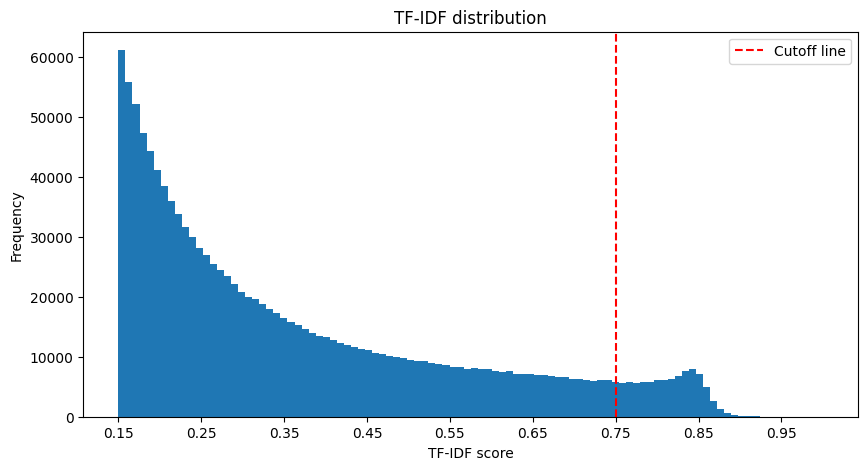

In [46]:
# Plot the tfidf distribution
plt.figure(figsize=(10, 5))
plt.hist(words_df['tfidf'], bins=100)
plt.title("TF-IDF distribution")
plt.xlabel("TF-IDF score")
plt.ylabel('Frequency')
# Add vertical line over X = 0.75
plt.axvline(x=0.75, color='red', linestyle='--', label='Cutoff line')
plt.xticks([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])
plt.legend(loc='upper right')
plt.show()

Let's add the graph for unknown (new) words.

In [47]:
unknown_words_freq = []
pctg_range = range(15, 100)
# For each segment, print the number of unknown words
for pctg in pctg_range:
    segment = words_df[(words_df['tfidf'] > pctg/100) & (words_df['tfidf'] <= (pctg+1)/100)]
    unknown_words = set(segment['word']) - set(vocab_df['word'])
    unknown_words_freq.append(len(unknown_words))

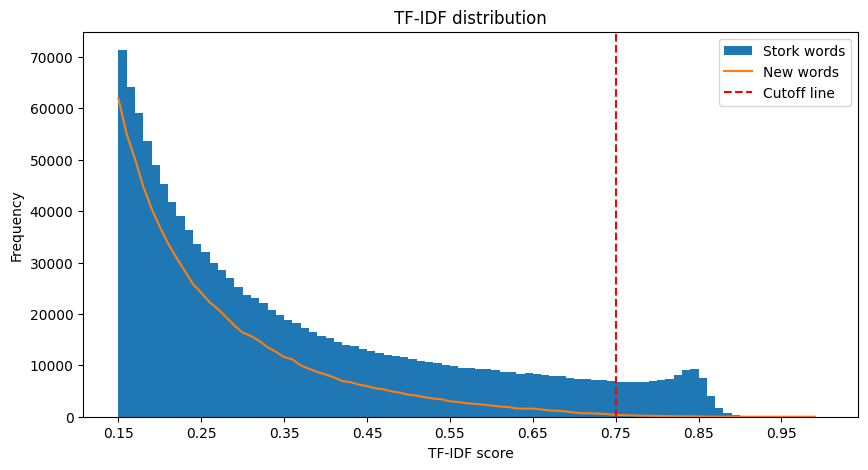

In [48]:
plt.figure(figsize=(10, 5))
plt.hist(words_df['tfidf'], bins=85, label='Stork words')
plt.plot(np.array(pctg_range)/100, unknown_words_freq, label='New words')
plt.title("TF-IDF distribution")
plt.xlabel("TF-IDF score")
plt.ylabel('Frequency')
# Add vertical line over X = 0.75
plt.axvline(x=0.75, color='red', linestyle='--', label='Cutoff line')
plt.xticks([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])
plt.legend(loc='upper right')
plt.show()

Let's zoom a bit.

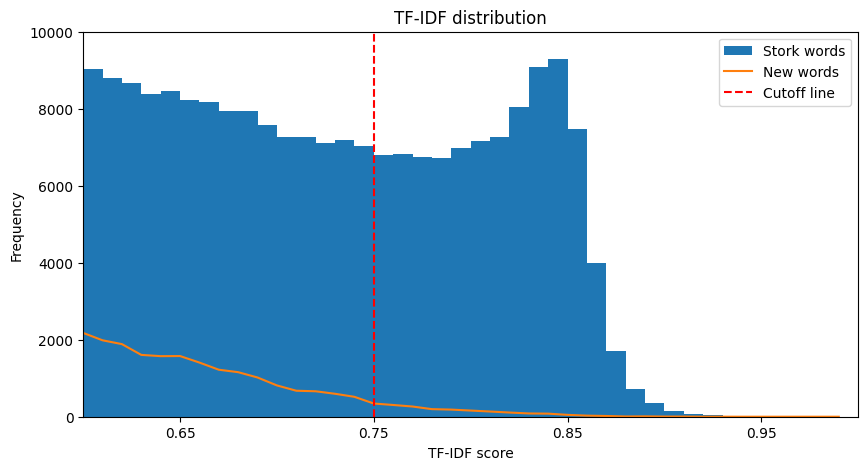

In [49]:
plt.figure(figsize=(10, 5))
plt.hist(words_df['tfidf'], bins=85, label='Stork words')
plt.plot(np.array(pctg_range)/100, unknown_words_freq, label='New words')
plt.title("TF-IDF distribution")
plt.xlabel("TF-IDF score")
plt.ylabel('Frequency')
# Add vertical line over X = 0.75
plt.axvline(x=0.75, color='red', linestyle='--', label='Cutoff line')
plt.ylim(0, 10000)
plt.xlim(0.60, 1.0)
plt.xticks([0.65, 0.75, 0.85, 0.95])
plt.legend(loc='upper right')
plt.show()

## 22. Merge with vocabulary

So far, we had `1 228 264` unique valid Bulgarian words in our vocabulary. Let's see what will be the merged set size.

In [50]:
vocab_set = set(vocab_df['word'].tolist()) # Current set
print(f"Number of words in vocabulary: {len(vocab_set):,}")

stork_words_set = set(words_df[words_df['tfidf'] > 0.75]['word'].tolist())
print(f"Number of words in stork words set (TFIDF > 0.75): {len(stork_words_set):,}")

# Let's merge the two sets
merged_vocab_set = vocab_set.union(stork_words_set)
print(f"Number of words in vocabulary (after merge): {len(merged_vocab_set):,}")

# Print the new words
print(sorted(merged_vocab_set - vocab_set))

Number of words in vocabulary: 1,228,264
Number of words in stork words set (TFIDF > 0.75): 89,481
Number of words in vocabulary (after merge): 1,230,247
['аблация', 'авва', 'авио', 'автоантитела', 'автозомно', 'авторке', 'автофокус', 'агар', 'агонисти', 'агранулоцитоза', 'адаптоген', 'адаптогени', 'аденоидит', 'аденокарцином', 'аденомиоза', 'аденомиозата', 'аджеба', 'аджика', 'аднексит', 'адювантна', 'адюнкта', 'адюнктата', 'аеро', 'аза', 'азелаинова', 'ази', 'азът', 'айде', 'айилци', 'айилците', 'айрян', 'аква', 'аки', 'акото', 'акупресурно', 'алах', 'алейна', 'алелуя', 'алиекспрес', 'алилуя', 'алкантара', 'алоу', 'алтер', 'аман', 'амблиопия', 'амбробене', 'аменорея', 'американ', 'амигдалата', 'амилия', 'амилоидоза', 'амин', 'амина', 'амини', 'амино', 'аминогликозиди', 'аминотрансфераза', 'амла', 'амниоцентеза', 'анавар', 'анастомоза', 'ангиоедем', 'ангиоми', 'ангиопатия', 'андрогенен', 'андрогенна', 'андрогенни', 'аневризъм', 'анкилозиращ', 'анонимизирани', 'антиваксър', 'антиваксър

* **OBSERVATION**: 2000 new words were added to the vocabulary.

In [51]:
# Sort and dump the new vocabulary
words = sorted(list(merged_vocab_set))
with open('data/words.txt', 'w', encoding='windows-1251') as f:
    for word in words:
        f.write(word + '\n')

# Convert to gzip
with open('data/words.txt', 'rb') as f_in:
    with gzip.open('data/words.txt.gz', 'wb') as f_out:
        f_out.writelines(f_in)

# Remove the original file
os.remove('data/words.txt')

print(f"Number of words written to file: {len(words):,}")

Number of words written to file: 1,230,247
